In [1]:
import pandas as pd
import numpy as np
from scipy.ndimage import label

# Cleaning the dataset

In [2]:
df= pd.read_csv('CTD_curated_genes_diseases.csv')

print(df.head())
#print(df.describe())
print(len(df))
print(df.shape)


  GeneSymbol  GeneID                DiseaseName     DiseaseID  \
0          A   50518                 Dermatitis  MESH:D003872   
1          A   50518          Diabetes Mellitus  MESH:D003920   
2          A   50518  Diabetes Mellitus, Type 2  MESH:D003924   
3          A   50518     Diabetic Nephropathies  MESH:D003928   
4          A   50518                      Edema  MESH:D004487   

     DirectEvidence OmimIDs PubMedIDs  
0  marker/mechanism     NaN  32937126  
1  marker/mechanism     NaN   1473152  
2  marker/mechanism     NaN   8146154  
3  marker/mechanism     NaN  37769864  
4  marker/mechanism     NaN  32937126  
34156
(34156, 7)


In [3]:
new_dataset = df.dropna(subset=['GeneSymbol','GeneID','DiseaseName','DiseaseID']) # remove all rows that have any missing values
new_dataset = new_dataset.drop(columns=['OmimIDs','PubMedIDs'])
new_dataset.drop_duplicates()
print(new_dataset.head())
print(len(new_dataset))
print(new_dataset.shape)

new_dataset.isnull().sum()

  GeneSymbol  GeneID                DiseaseName     DiseaseID  \
0          A   50518                 Dermatitis  MESH:D003872   
1          A   50518          Diabetes Mellitus  MESH:D003920   
2          A   50518  Diabetes Mellitus, Type 2  MESH:D003924   
3          A   50518     Diabetic Nephropathies  MESH:D003928   
4          A   50518                      Edema  MESH:D004487   

     DirectEvidence  
0  marker/mechanism  
1  marker/mechanism  
2  marker/mechanism  
3  marker/mechanism  
4  marker/mechanism  
34156
(34156, 5)


GeneSymbol        0
GeneID            0
DiseaseName       0
DiseaseID         0
DirectEvidence    0
dtype: int64

# Creating the graph

In [4]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import networkx as nx
import torch
import matplotlib.pyplot as plt

# 1. Prepare the OneHotEncoder for 'DirectEvidence'
# Create and fit a one-hot encoder, which will convert these text labels into numeric vectors (e.g., ['genetic'] → [1, 0, 0, ...]).
# evidence_list is an array like ["TAS", "NAS", "IEA", "EXP"]
# .reshape(-1, 1) turns it into a 2D array because OneHotEncoder expects column-based data.
# encoder.transform([["TAS"]])  →  [[1. 0. 0. 0.]]
evidence_list = new_dataset['DirectEvidence'].dropna().unique()
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(evidence_list.reshape(-1, 1))

# 2. Pre-encode all evidence values (vectorized)
# It wraps evidence in a double bracket ([[evidence]]) because the encoder expects a 2D input.
# The [0] gets the first row from the result (since it always returns a list of lists).
# Save the encoded vector in a new column: 'EncodedEvidence'
def encode_evidence(evidence):
    if pd.notna(evidence):
        return encoder.transform([[evidence]])[0]
    else:
        return [0] * len(evidence_list)

new_dataset['EncodedEvidence'] = new_dataset['DirectEvidence'].apply(encode_evidence)

# 3. Create graph
G = nx.Graph()

# 4. Add gene nodes (unique)
genes = new_dataset[['GeneID', 'GeneSymbol']].drop_duplicates()
G.add_nodes_from(
    (row.GeneID, {'type': 'gene', 'label': row.GeneSymbol})
    for row in genes.itertuples(index=False)
)

# 5. Add disease nodes (unique)

# Gene node G1 is added once.
# Disease nodes D1, D2, D3 are added once each.
# Then it adds three edges:
# G1 — D1 with evidence: genetic
# G1 — D2 with evidence: expression
# G1 — D3 with evidence: mutation

diseases = new_dataset[['DiseaseID', 'DiseaseName']].drop_duplicates()
G.add_nodes_from(
    (row.DiseaseID, {'type': 'disease', 'label': row.DiseaseName})
    for row in diseases.itertuples(index=False)
)

# 6. Add edges with encoded evidence
# Each edge carries an evidence attribute — a tensor representing the encoded evidence.
# This keeps all gene–disease pairs, even if they share the same gene or disease.
edges = [
    (row.GeneID, row.DiseaseID, {'evidence': torch.tensor(row.EncodedEvidence, dtype=torch.float)})
    for row in new_dataset.itertuples(index=False)
]
G.add_edges_from(edges)

# 7. Add node features: [is_gene, is_disease, degree]
# Add a feature vector:
# [1, 0, degree] → if it's a gene
# [0, 1, degree] → if it's a disease
for node, data in G.nodes(data=True):
    is_gene = 1 if data['type'] == 'gene' else 0
    is_disease = 1 - is_gene
    degree = G.degree(node)
    G.nodes[node]['x'] = torch.tensor([is_gene, is_disease, degree], dtype=torch.float)


print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


for node in list(G.nodes)[:5]:
    print(f"Node {node}, type {G.nodes[node]['type']}, features {G.nodes[node]['x']}")

for u, v in list(G.edges)[:5]:
    print(f"Edge ({u}, {v}) evidence: {G[u][v].get('evidence', None)}")

# Plotting

# labels = {
#     node: str(node).replace("MESH:","").replace("OMIM:","")
#     for node in G.nodes
# }
# pos = nx.spring_layout(G,seed=2, k=0.5) # bigger k than more space between nodes
# #pos = nx.kamada_kawai_layout(G)
# colors = ["red" if G.nodes[n]["type"] == "gene" else "blue" for n in G.nodes]
# # plt.figure(figsize=(20,20))
# # nx.draw_networkx(G,pos= pos,labels= labels, node_color=colors, with_labels=True, edge_color='black', node_size=1000, font_size=8, font_color='black', font_weight='bold')
# # plt.show()

Number of nodes: 14967
Number of edges: 34156
Node 50518, type gene, features tensor([ 1.,  0., 18.])
Node 1, type gene, features tensor([1., 0., 2.])
Node 2, type gene, features tensor([ 1.,  0., 11.])
Node 144568, type gene, features tensor([1., 0., 1.])
Node 53947, type gene, features tensor([1., 0., 1.])
Edge (50518, MESH:D003872) evidence: tensor([1., 0., 0.])
Edge (50518, MESH:D003920) evidence: tensor([1., 0., 0.])
Edge (50518, MESH:D003924) evidence: tensor([1., 0., 0.])
Edge (50518, MESH:D003928) evidence: tensor([1., 0., 0.])
Edge (50518, MESH:D004487) evidence: tensor([1., 0., 0.])


# Testing with a mini subgraph

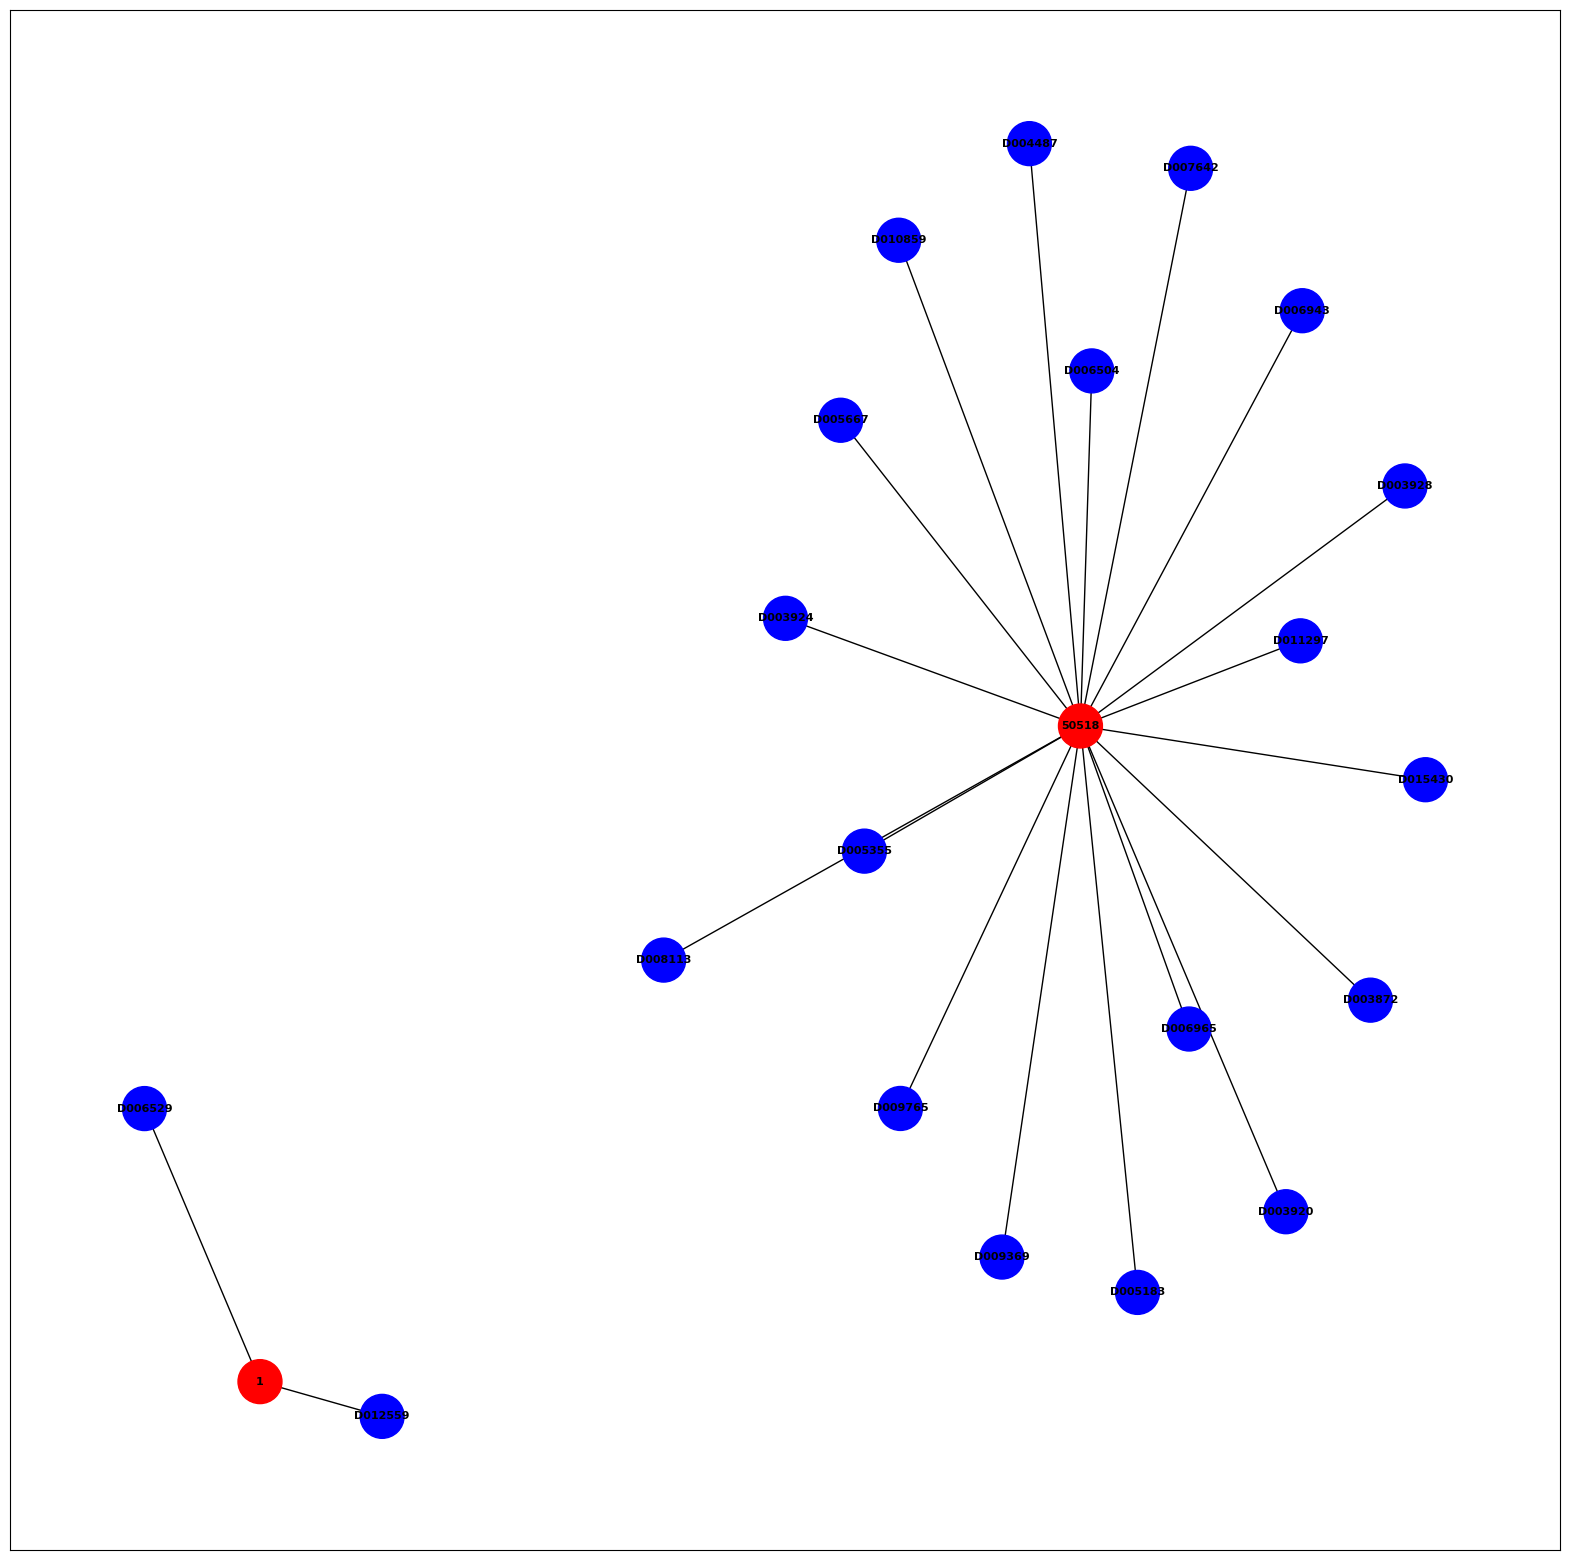

My subgraph:  Graph with 22 nodes and 20 edges


In [5]:
sub_edge = list(G.edges())[:20]
H = G.edge_subgraph(sub_edge).copy()

labels_H = {
    node: str(node).replace("MESH:","").replace("OMIM:","")
    for node in H.nodes
}
pos_H = nx.spring_layout(H,seed=2, k=0.5) # bigger k than more space between nodes
colors_H = ["red" if H.nodes[n]["type"] == "gene" else "blue" for n in H.nodes]
plt.figure(figsize=(20,20))
nx.draw_networkx(H,pos= pos_H,labels= labels_H, node_color=colors_H, with_labels=True, edge_color='black', node_size=1000, font_size=8, font_color='black', font_weight='bold')
plt.show()

print("My subgraph: ",H)

# Degree Centrality

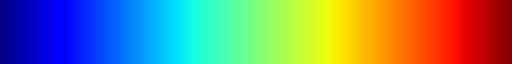

In [6]:
plt.cm.jet

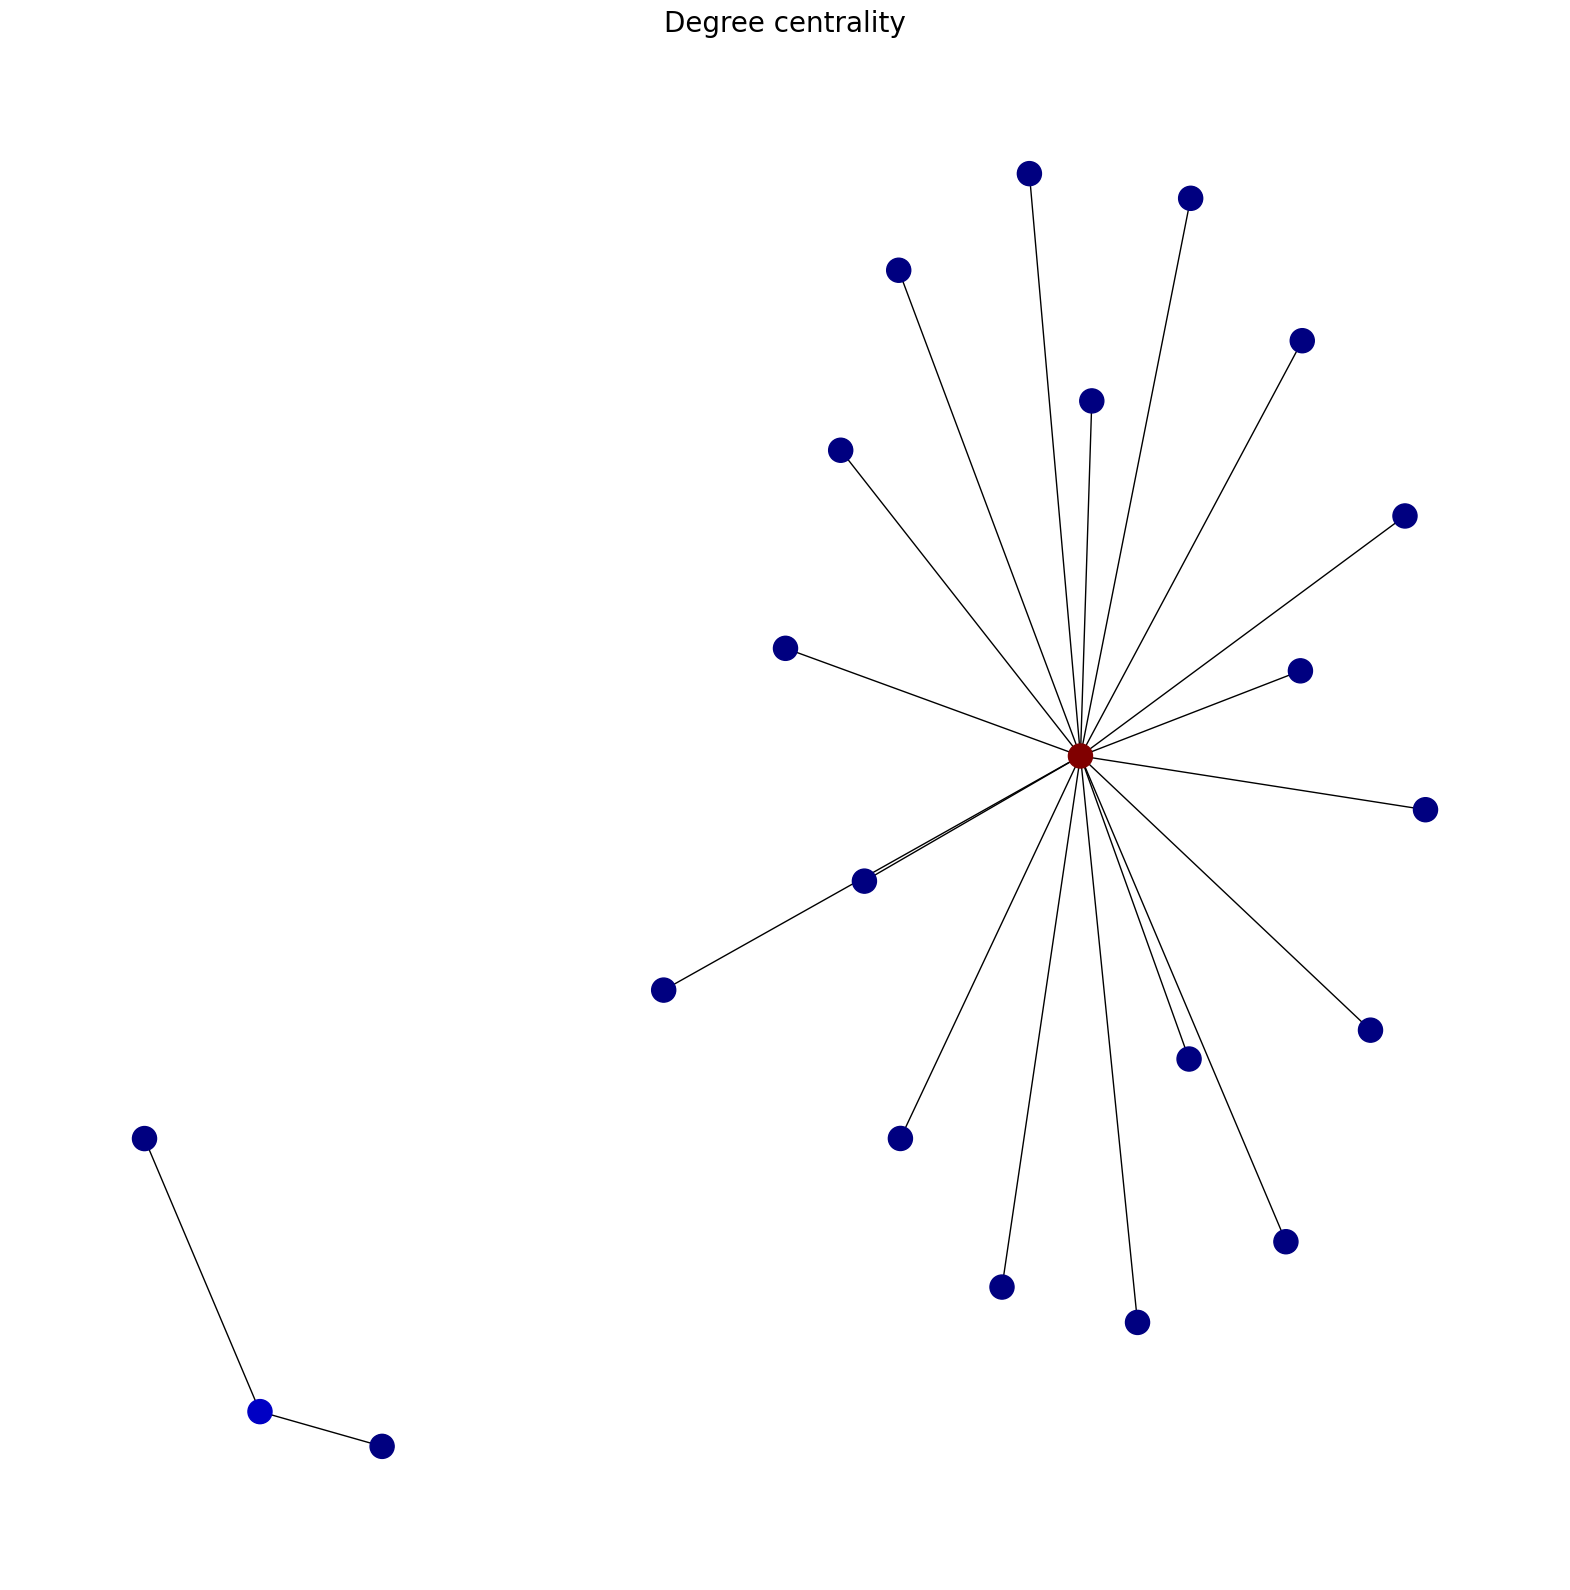

In [7]:
deg_colors = list(H.degree(n) for n in H.nodes)

plt.figure(figsize=(20,20))
plt.title("Degree centrality", size=20)
nx.draw(H, pos=pos_H, node_color=deg_colors, cmap=plt.cm.jet)

# Betweeness

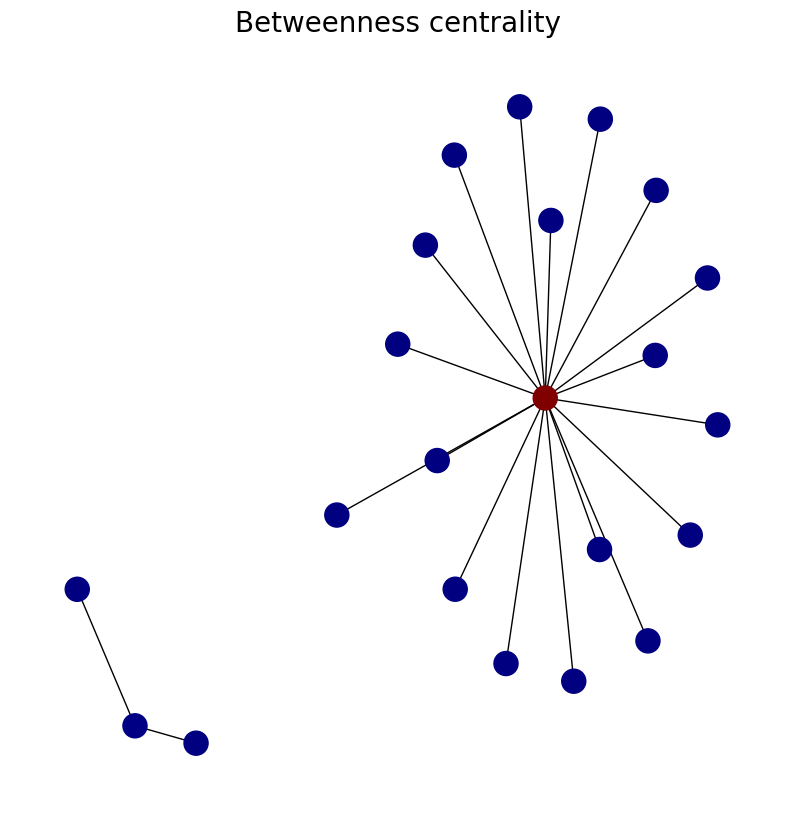

In [8]:
btw_colors = list(nx.betweenness_centrality(H).values())

plt.figure(figsize=(10, 10))
plt.title("Betweenness centrality", size=20)
nx.draw(H, pos=pos_H, node_color=btw_colors, cmap=plt.cm.jet)

# Closeness

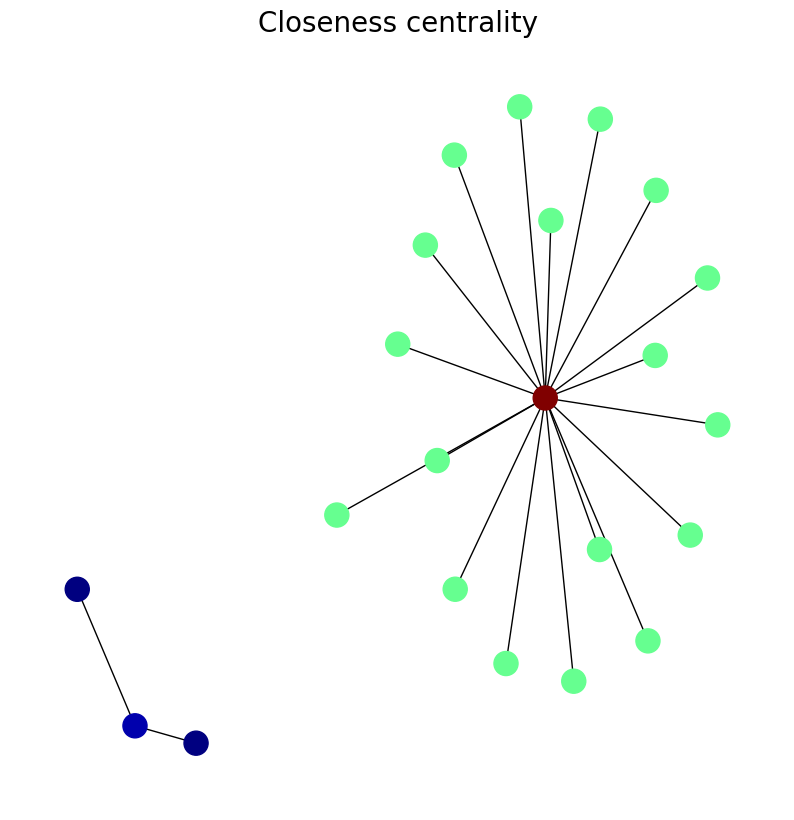

In [9]:
btw_colors = list(nx.closeness_centrality(H).values())

plt.figure(figsize=(10, 10))
plt.title("Closeness centrality", size=20)
nx.draw(H, pos=pos_H, node_color=btw_colors, cmap=plt.cm.jet)

# Communities: Modularity

In [10]:
from typing import List, Set

from networkx.algorithms.community.quality import (
    is_partition,
    modularity,
)

def my_modularity(G: nx.Graph, communities: List[Set]) -> float:
    """
    Calculate modularity given a graph G and a list of communities
    """
    assert is_partition(G, communities), "communities must be a partition of G's nodes"
    m = G.number_of_edges()
    Q = 0
    for community in communities:
        s = nx.subgraph(G, community)  # group s
        ms = s.number_of_edges()
        ks = sum(G.degree(u) for u in s.nodes)
        Q += ms / m - (ks / (2 * m)) ** 2
    return Q

## Graph Partitioning

In [11]:
def communities_to_dict(com: list):
    """Transforms a communities list formed from a list of sets
    [{u1, u2, ...}, {v1, v2, ...}, ...] into a {node:community} dict
    """
    d = {}
    for v in range(len(com)):
        for k in com[v]:
            d[k] = v
    return d

### Girvan Newman

In [12]:
import itertools
from networkx.algorithms.community import girvan_newman

## This is from the `girvan_newman` docs
k = 12  # take at most k elements for each community
comp = girvan_newman(H)
# Take the last partition with <= k communities
limited = itertools.takewhile(lambda c: len(c) <= k, comp)

for communities in limited:
    communities = list(sorted(str(c)) for c in communities)

d = communities_to_dict(communities)


node_color = list(d.values())  # Community color
#plt.title(f"Partitioned\n{len(communities) = }\n{modularity(H, communities) = :.2f}")


# GNN

In [13]:
import os
import sys

import matplotlib.pyplot as plt
import networkx as nx
from sklearn.manifold import TSNE

import torch
import torch_geometric.nn as pyg_nn
from torch import nn
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import Planetoid, TUDataset
from torch_geometric.utils import from_networkx, to_networkx, train_test_split_edges
from tqdm.notebook import tqdm

from torch_geometric.nn import GCN, MLP, GCNConv, GATConv
from torchinfo import summary

import copy
import os

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import torch.nn.functional as F
import torch_geometric.transforms as py_T
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.utils import negative_sampling
from tqdm.notebook import tqdm

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device = }")

device = 'cpu'


In [15]:
from torch_geometric.transforms import RandomLinkSplit

# Convert your NetworkX graph G (already encoded) to PyG Data object
data_G = from_networkx(G, group_node_attrs=['x'], group_edge_attrs=['evidence'])

data= data_G.clone()

transform = RandomLinkSplit(
        is_undirected=True,
        add_negative_train_samples=True,
        #key='evidence',
        split_labels=True
    )
train_data, val_data, test_data = transform(data)

def merge_edge_labels(data):
    edge_label_index = torch.cat([data.pos_edge_label_index, data.neg_edge_label_index], dim=1)
    edge_label = torch.cat([data.pos_edge_label, data.neg_edge_label], dim=0)
    data.edge_label_index = edge_label_index
    data.edge_label = edge_label
    return data

train_data = merge_edge_labels(train_data)
val_data = merge_edge_labels(val_data)
test_data = merge_edge_labels(test_data)

print(train_data)



Data(edge_index=[2, 47820], type=[14967], label=[14967], x=[14967, 3], edge_attr=[47820, 3], pos_edge_label=[23910], pos_edge_label_index=[2, 23910], neg_edge_label=[23910], neg_edge_label_index=[2, 23910], edge_label_index=[2, 47820], edge_label=[47820])


In [22]:
class LinkPredModel(torch.nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        dropout: float = 0.3,
        negative_slope: float = 0.2,
        dot_product: bool = True,
    ):
        super(LinkPredModel, self).__init__()

        # Convolution layers
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        if not dot_product:
            self.classifier = torch.nn.Linear(2 * hidden_dim, 1)  # hardcoded output dim

        self.loss_fn = torch.nn.BCEWithLogitsLoss()

        self.negative_slope = negative_slope
        self.dropout = dropout
        self.dot_product = dot_product

    def forward(self, x, edge_index, edge_label_index):

        # Compute embeddings
        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x, negative_slope=self.negative_slope)
        if self.training:
            x = F.dropout(x, p=self.dropout)
        x = self.conv2(x, edge_index)

        x_src = x[edge_label_index[0]]  # Take the embeddings of the source nodes
        x_trg = x[edge_label_index[1]]  # Take the embeddings of the targe nodes

        # dot product h^t * h
        if self.dot_product:
            out = torch.sum(x_src * x_trg, dim=1)  # Dot product
        else:
            # Concat and MLP version
            x = torch.cat([x_src, x_trg], dim=1)
            # x = torch.sum([x_src, x_trg], dim = 1)
            out = self.classifier(x).squeeze()

        return out

    def loss(self, preds, link_label):
        return self.loss_fn(preds, link_label.type(preds.dtype))

In [20]:
model = LinkPredModel(data.num_node_features, 128, dot_product=True)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01,  weight_decay=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()



In [21]:
def train(model, data_train, data_val, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data_train.x, data_train.edge_index, data_train.edge_label_index)
    loss = model.loss(out, data_train.edge_label)
    loss.backward()
    optimizer.step()

    loss_train, acc_train = test(model, data_train)
    loss_val, acc_val = test(model, data_val)
    return loss_train, acc_train, loss_val, acc_val


@torch.no_grad()
def test(model, data):
    out = model(data.x, data.edge_index, data.edge_label_index)
    loss = model.loss(out, data.edge_label.type(out.dtype))
    acc = accuracy_score(
        data.edge_label.detach().cpu(),
        torch.sigmoid(out).round().detach().cpu().numpy(),
    )
    # acc = accuracy_score(data.edge_label.detach().cpu(), torch.argmax(out, axis = 1).detach().cpu().numpy())

    return loss.item(), acc

epochs = 51
best_model, best_loss = None, None
for epoch in range(epochs):
    loss_train, acc_train, loss_val, acc_val = train(model, train_data, val_data, optimizer)
    # Save best model
    if best_loss is None or loss_val < best_loss:
        best_model = copy.deepcopy(model)
        best_loss = loss_val
        best_epoch = epoch
    if epoch % 10 == 0:
        print(f"{epoch=} \t {loss_train=:.2f} | {acc_train=:.2f} \t {loss_val=:.2f} | {acc_val=:.2f}")

epoch=0 	 loss_train=41727.95 | acc_train=0.50 	 loss_val=43895.88 | acc_val=0.50
epoch=10 	 loss_train=7511.56 | acc_train=0.51 	 loss_val=9701.34 | acc_val=0.51
epoch=20 	 loss_train=5380.24 | acc_train=0.50 	 loss_val=3024.95 | acc_val=0.53
epoch=30 	 loss_train=2678.41 | acc_train=0.52 	 loss_val=1823.60 | acc_val=0.49
epoch=40 	 loss_train=1165.99 | acc_train=0.61 	 loss_val=1393.41 | acc_val=0.55
epoch=50 	 loss_train=696.07 | acc_train=0.57 	 loss_val=759.60 | acc_val=0.49
